<a href="https://colab.research.google.com/github/shotatakahara/Castle_Classification/blob/main/CastleClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from __future__ import absolute_import, division, print_function
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### road data

In [3]:
#データ読込
traindata = np.load(r"/content/drive/MyDrive/1_deliverable/castle/castle_data.npy")
trainlabel = np.load(r"/content/drive/MyDrive/1_deliverable/castle/label.npy")

In [4]:
#大きさ確認
print(traindata.shape)
print(trainlabel.shape)
u, counts = np.unique(trainlabel, return_counts=True)
print(u,counts)

(541, 224, 224, 3)
(541,)
[0. 1.] [293 248]


In [5]:
#欠損値確認
print(np.count_nonzero(np.isnan(traindata)))
print(np.count_nonzero(np.isnan(trainlabel)))

0
0


In [6]:
X_train, X_val, y_train, y_val = train_test_split(traindata,
                                                  trainlabel,
                                                  test_size=0.1,
                                                  random_state=2021,
                                                  shuffle=True,
                                                  stratify=trainlabel)#trainとvalで比率を同じにする

In [7]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(486, 224, 224, 3)
(55, 224, 224, 3)
(486,)
(55,)


#### 学習

In [34]:
model = keras.Sequential([keras.layers.Conv2D(filters=16,
                                              kernel_size=(3, 3),
                                              strides=(1, 1),
                                              padding='same',
                                              data_format='channels_last',#(batch, height, width, channels)"
                                              name='conv_1',
                                              activation='relu'),
                          keras.layers.MaxPool2D(pool_size=(2, 2),
                                                 name='pool_1'),
                          keras.layers.Conv2D(filters=32,
                                              kernel_size=(3, 3),
                                              strides=(1, 1),
                                              padding='same',
                                              data_format='channels_last',#(batch, height, width, channels)"
                                              name='conv_2',
                                              activation='relu'),
                          keras.layers.MaxPool2D(pool_size=(2, 2),
                                                 name='pool_2'),
                          keras.layers.Conv2D(filters=64,
                                              kernel_size=(3, 3),
                                              strides=(1, 1),
                                              padding='same',
                                              data_format='channels_last',#(batch, height, width, channels)"
                                              name='conv_3',
                                              activation='relu'),
                          keras.layers.MaxPool2D(pool_size=(2, 2),
                                                 name='pool_3'),
                          keras.layers.Flatten(input_shape=(32,32,32)),
                          keras.layers.Dropout(rate=0.5),
                          keras.layers.Dense(1200, activation='relu'),
                          keras.layers.Dropout(rate=0.5),
                          keras.layers.Dense(120, activation='relu'),
                          keras.layers.Dropout(rate=0.5),
                          keras.layers.Dense(2, activation='softmax')#labelの数の出力と合うように設定
                         ])
model.build(input_shape=(None, 224, 224, 3))

model.compile(optimizer='adam',#どのように学習させるか
              loss='sparse_categorical_crossentropy',#誤差関数
              metrics=['accuracy'])#監視するもの

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 56, 56, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 56, 56, 64)        18496     
_________________________________________________________________
pool_3 (MaxPooling2D)        (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)            

In [35]:
#コールバック設定
es = EarlyStopping(monitor='val_loss',#監視対象
                   patience=10,#監視対象の値がこの数が改善されなければ止める
                   verbose=1)
cp = ModelCheckpoint(filepath = '/content/drive/MyDrive/1_deliverable/castle/best_model.h5',#最良モデルをこの名前で保存
                     monitor='val_loss',#監視対象
                     save_best_only=True,
                     verbose=1)

   
Learning=model.fit(x=X_train, 
                   y=y_train, 
                   validation_data=(X_val, y_val), 
                   #batch_size=32, 
                   epochs=100,
                   callbacks=[es, cp], #コールバックの指定
                   shuffle=True)


Epoch 1/100
16/16 [==============================] - 1s 57ms/step - loss: 2.4258 - accuracy: 0.5329 - val_loss: 0.6883 - val_accuracy: 0.5455

Epoch 00001: val_loss improved from inf to 0.68830, saving model to /content/drive/MyDrive/1_deliverable/castle/best_model.h5
Epoch 2/100
16/16 [==============================] - 1s 51ms/step - loss: 0.6890 - accuracy: 0.5576 - val_loss: 0.6779 - val_accuracy: 0.5455

Epoch 00002: val_loss improved from 0.68830 to 0.67791, saving model to /content/drive/MyDrive/1_deliverable/castle/best_model.h5
Epoch 3/100
16/16 [==============================] - 1s 49ms/step - loss: 0.6732 - accuracy: 0.5658 - val_loss: 0.6702 - val_accuracy: 0.6545

Epoch 00003: val_loss improved from 0.67791 to 0.67016, saving model to /content/drive/MyDrive/1_deliverable/castle/best_model.h5
Epoch 4/100
16/16 [==============================] - 1s 46ms/step - loss: 0.6557 - accuracy: 0.6255 - val_loss: 0.7744 - val_accuracy: 0.4545

Epoch 00004: val_loss did not improve from

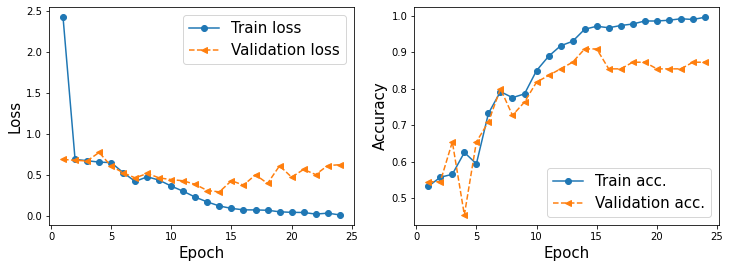

In [36]:
hist = Learning.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
# loss graph作成
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
# acc graph作成
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

# 最良モデルの復元

In [38]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/1_deliverable/castle/best_model.h5')
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 56, 56, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 56, 56, 64)        18496     
_________________________________________________________________
pool_3 (MaxPooling2D)        (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)            

In [40]:
# リストアされたモデルを評価
loss, acc = new_model.evaluate(X_val,y_val, verbose=1)#verboseは表示モード
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

2/2 [==============================] - 0s 14ms/step - loss: 0.2923 - accuracy: 0.9091
Restored model, accuracy: 90.91%


# 転移学習

In [25]:
from keras.applications.vgg16 import VGG16
base_model = VGG16(weights='imagenet', include_top=False,input_shape=(224,224,3) ,pooling="avg")#画像なのでImage-net,全結合層ありならばTrue

X_train_vgg16 = base_model.predict(X_train)
X_val_vgg16 = base_model.predict(X_val)

In [26]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [27]:
from sklearn.svm import SVC
clf = SVC(kernel="rbf").fit(X_train_vgg16, y_train)

from sklearn.metrics import accuracy_score
print("acc = {}".format(accuracy_score(clf.predict(X_train_vgg16), y_train)))
print("val_acc = {}".format(accuracy_score(clf.predict(X_val_vgg16), y_val)))

acc = 0.9650205761316872
val_acc = 0.9636363636363636


In [28]:
clf.predict(X_val_vgg16)

array([0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0.,
       1., 0., 1., 0.])